In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline

import glam

# Example 2: Three small groups with difference in gaze bias

In some research settings, the total amount of data can be quite small, conflicting with the amounts of data usually necessary to obtain reliable and precise parameter estimates from diffusion models. To alleviate this, hierarchical approaches can be made, where data from individuals inform estimates of parameters of the group, to the extent that they are informative. Such hierarchical parameter estimation can greatly improve parameter estimation in face of limited amounts of data (cf. the HDDM toolbox for hierarchical modeling using the Drift Diffusion Model).

Here, we will simulate a clinical setting, in which different patient groups are to be compared on their gaze biases during a simple value-based choice task, that includes eye tracking. One could imagine that the data that can be generated within this setting is limited on at least two accounts:

1. The number of patients with certain conditions that are available for the experiment might be low
2. The number of trials that can be performed by each individual might also be low, for clinical reasons (e.g., patients feel exhausted earlier, ...)

Therefore, the dataset we generate will contain only low numbers of individuals within each group, and only 50 trials (roughly corresponding to a 15-minute experimental) per participant.

We will then estimate model parameters in a hierarchical fashion, and compare the group level gaze bias parameters between groups.

## Simulate data

We simulate the data such that only the gaze bias parameter $\gamma$ differs between the groups, with means of 1.0 (no gaze bias), 0.3 (moderate gaze bias) and -0.5 (strong gaze bias), respectively. All other parameters are drawn from the same distributions across groups:

In [2]:
np.random.seed(1523)

N = dict(group1=7,
         group2=12,
         group3=5)

v = dict(group1=np.clip(np.random.normal(loc=0.0001, scale=0.00005, size=N['group1']), a_min=0, a_max=None),
         group2=np.clip(np.random.normal(loc=0.0001, scale=0.00005, size=N['group2']), a_min=0, a_max=None),
         group3=np.clip(np.random.normal(loc=0.0001, scale=0.00005, size=N['group3']), a_min=0, a_max=None))

s = dict(group1=np.clip(np.random.normal(loc=0.008, scale=0.001, size=N['group1']), a_min=0, a_max=None),
         group2=np.clip(np.random.normal(loc=0.008, scale=0.001, size=N['group2']), a_min=0, a_max=None),
         group3=np.clip(np.random.normal(loc=0.008, scale=0.001, size=N['group3']), a_min=0, a_max=None))

gamma = dict(group1=np.clip(np.random.normal(loc=1.0, scale=0.2, size=N['group1']), a_min=None, a_max=1),
             group2=np.clip(np.random.normal(loc=0.3, scale=0.4, size=N['group2']), a_min=None, a_max=1),
             group3=np.clip(np.random.normal(loc=-0.5, scale=0.2, size=N['group3']), a_min=None, a_max=1))

tau = dict(group1=np.clip(np.random.normal(loc=1, scale=0.1, size=N['group1']), a_min=0, a_max=None),
           group2=np.clip(np.random.normal(loc=1, scale=0.1, size=N['group2']), a_min=0, a_max=None),
           group3=np.clip(np.random.normal(loc=1, scale=0.1, size=N['group3']), a_min=0, a_max=None))

n_trials = 100
n_items = 3

model = glam.GLAM()

groups = ['group1', 'group2', 'group3']
for group in groups:
    model.simulate_group(kind='individual', n_individuals=N[group], n_trials=n_trials, n_items=n_items,
                         parameters=dict(v=v[group], gamma=gamma[group], s=s[group], t0=np.zeros(N[group]), tau=tau[group]),
                         label=group)

data = model.data.copy()

This is what the generated data looks like:

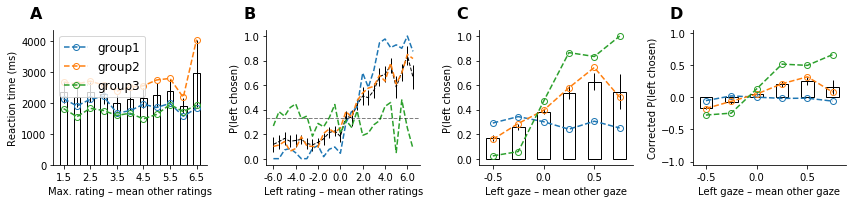

In [3]:
glam.plot_fit(data=data,
              predictions=[data.loc[data['condition'] == group] for group in groups],
              prediction_labels=groups);

Even though the data were generated only with different gaze biases, the groups behaviourally also differ in response times (Panel A; with group one being slower as groups one and three) and choice accuracy (Panel B; group three clearly less accurate than the other, and group one more accurate than the others). As was to be expected, we can also observe behavioural differences in gaze influence measures (Panels C and D).

## Hierarchical model

We now set up the hierarchical model, where we assume that every group has a distinct average gaze bias, which we then estimate.

![glam_hierarchical_illustration](figures/hierarchical_glam_illustration.png)

!! Include a section to talk about priors. !!

Since we use `PyMC3` to build our models and infer parameter estimates, we can use all inference techniques supplied by `PyMC3`. 

### MCMC

As before, we can use a traditional Markov-Chain-Monte-Carlo approach, with the Metropolis-Hastings algorithm. While this algorithm produces highly correlated samples, it can still obtain a reasonable number of effective samples, because it runs relatively fast. However, convergence should definitely diagnosed. We recommend to draw as many samples as possible within your time frame, and especially allowing the sampler to tune itself to make sure it is exploring the relevant region of the parameter space. If you observe slow drifts in the traces, consider increasing the number of tuning samples further. Even though the sampler can be parallelized, each chain running in parallel needs to draw the same number of tuning samples, so this process unfortunately cannot be cut short.

In [4]:
model_hierarchical_mcmc = glam.GLAM(data=model.data.copy())
model_hierarchical_mcmc.make_model(kind='hierarchical',
                                   depends_on=dict(gamma='condition'),
                                   t0_val=0)

Generating hierarchical model for 24 subjects...


/Users/felixmolter/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/felixmolter/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/felixmolter/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tupl

In [ ]:
model_hierarchical_mcmc.fit(method='MCMC', step=None, draws=5000, tune=1000, cores=2, chains=2, seed=1556, init='advi+adapt_diag', n_init=50000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Fitting 1 model(s) using MCMC...
  Fitting model 1 of 1...


Average Loss = 20,065:  58%|█████▊    | 28996/50000 [02:47<02:00, 173.93it/s]
Convergence achieved at 29000
Interrupted at 28,999 [57%]: Average Loss = 21,352
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, tau_sd, tau_mu, s, s_sd, s_mu, gamma_group3, gamma_group2, gamma_group1, gamma_group3_sd, gamma_group2_sd, gamma_group1_sd, gamma_group3_mu, gamma_group2_mu, gamma_group1_mu, v, v_sd, v_mu]
Sampling 2 chains:  12%|█▏        | 1473/12000 [48:54<8:12:41,  2.81s/draws] 

!! Brief paragraph about convergence and convergence diagnostics? !!

In [ ]:
pm.traceplot(model_hierarchical_mcmc.trace[0]);

#### Parameter estimates

In [ ]:
glam.plots.plot_node(model_hierarchical_mcmc, parameter='gamma',
                     comparisons=[('group1', 'group2'), ('group1', 'group3'), ('group2', 'group3')]);

In [ ]:
# Mean individual estimated parameters
model_hierarchical_mcmc.estimates.groupby('condition')['gamma'].mean()

In [ ]:
# Group level estimates
model_hierarchical_mcmc.estimates.groupby('condition')['gamma_mu'].mean()

In [ ]:
# Mean individual generating parameters
{group: gamma[group].mean() for group in groups}

### Variational Inference

Alternatively, we can use the methods for variational inference that ship with PyMC3:

In [ ]:
model_hierarchical_vi = glam.GLAM(data=model.data.copy())
model_hierarchical_vi.make_model(kind='hierarchical',
                                 depends_on=dict(gamma='condition'),
                                 t0_val=0)
model_hierarchical_vi.fit(method='VI')

Generally, the variational inference methods are faster than the MCMC methods, but they can also yield less accurate results. For one, they assume that each parameter's posterior distribution can be well approximated by a normal distribution. Obviously this assumption can lead to very wrong inferences, when violated.

#### Parameter estimates

After the model has been fit, the same analysis as before can be performed:

In [ ]:
glam.plots.plot_node(model_hierarchical_vi, parameter='gamma',
                     comparisons=[('group1', 'group2'), ('group1', 'group3'), ('group2', 'group3')]);

In [ ]:
# Mean individual estimated parameters
model_hierarchical_vi.estimates.groupby('condition')['gamma'].mean()

In [ ]:
# Group level estimates
model_hierarchical_vi.estimates.groupby('condition')['gamma_mu'].mean()

In [ ]:
# Mean individual generating parameters
{group: gamma[group].mean() for group in groups}

The estimated mean gaze bias parameters of the groups closely resemble the (usually unknown, but in this simulated case known) data-generating parameters.

We could now conclude, that the groups all differ in their gaze bias: Group 1 has a lower gaze bias (higher $\gamma$) than Group 2 (Mean difference = 0.64, 95% HPD = [0.44, 0.85]) and Group 3 (Mean difference = 1.57, 95% HPD = [1.47, 1.68]), whereas Group 2 has a lower gaze bias than Group 3 (Mean difference = 0.93, 95% HPD = [0.72, 1.16]).

*INTERNAL: THE POSTERIORS FROM MCMC AND ADVI LOOK PRETTY SIMILAR. I SUSPECT THIS IS DUE TO SOMETHING NOT CONVERGING IN MCMC..*